# Replace long-period Keplerians with linear, or curvature, trends. Run mcmc on zero-planet model.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import radvel
from radvel.plot import orbit_plots, mcmc_plots
import rvsearch

## Load the final search posteriors for test stars. Extract the RV data, and subtract the best-fit gamma offsets for the pre- and post-upgrade sets.

In [8]:
post = radvel.posterior.load('3074a/post_final.pkl')
post.params['dvdt'].vary = True
post.params['k1'].vary = False
post.params['secosw1'].vary = False
post.params['sesinw1'].vary = False
post.params['per1'].vary = False
post.params['tc1'].vary = False

post.params['k1'].value = 0
post.params['secosw1'].value = 0
post.params['sesinw1'].value = 0
post.params['jit_j'].value = 2.
post.params['jit_k'].value = 2.
post.medparams = {}
post.maxparams = {}
post.uparams = {}

post = radvel.fitting.maxlike_fitting(post)

Initial loglikelihood = -2719.256700
Performing maximum likelihood fit...
Final loglikelihood = -99.058781
Best-fit parameters:
parameter                     value       +/-      vary
per1                        11398.8         0     False
tc1                         37591.7         0     False
secosw1                           0         0     False
sesinw1                           0         0     False
k1                                0         0     False
jit_j                       4.51476         0      True
jit_k                       5.61535         0      True
gamma_k                     11.5796         0      True
gamma_j                     27.2778         0      True
dvdt                     -0.0101294         0      True
curv                              0         0     False
tp1                           34742         0          
e1                                0         0          
w1                                0         0          

Priors
------
K constrained to 

## Run mcmc on the 0-planet, linear model.

200000/4000000 (5.0%) steps complete; Running 11786.63 steps/s; Mean acceptance rate = 54.7%; Min Tz = 18604.3; Max G-R = 1.001      
Discarding burn-in now that the chains are marginally well-mixed

280000/4000000 (7.0%) steps complete; Running 11046.34 steps/s; Mean acceptance rate = 54.3%; Min Tz = 10057.0; Max G-R = 1.003      
Chains are well-mixed after 280000 steps! MCMC completed in 23.3 seconds


Corner plot saved to 3074a_trend/corner_plot.pdf
RV multi-panel plot saved to 3074a_trend/orbit_plot_mc.pdf


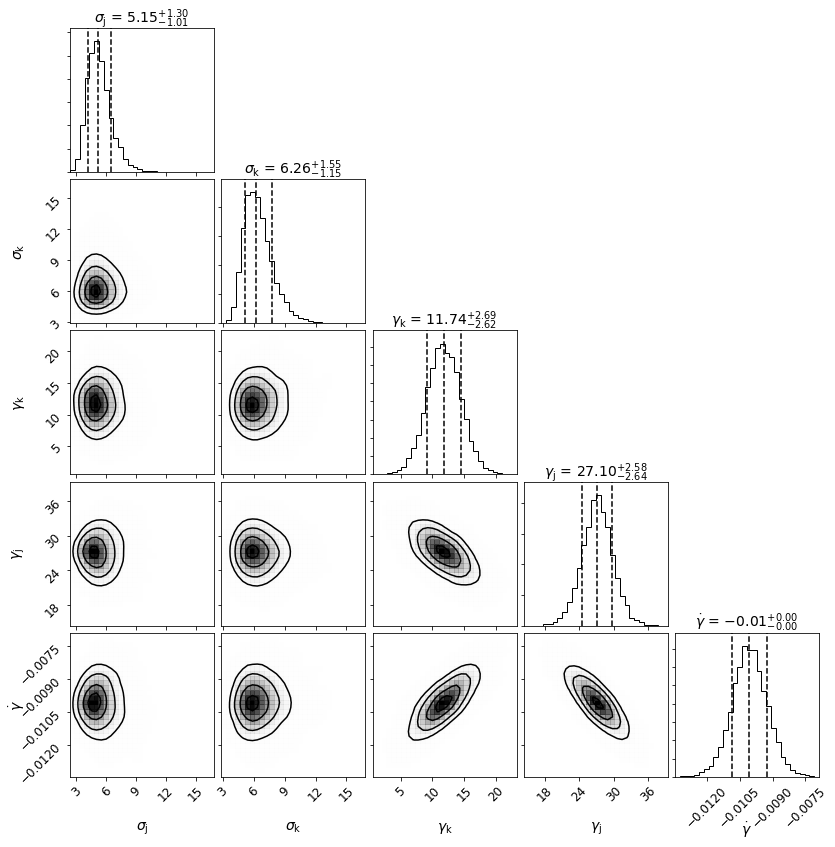

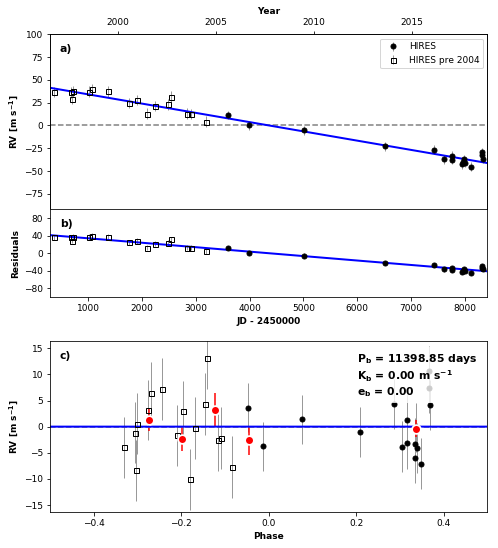

In [21]:
outdir = '3074a_trend'
post.uparams   = {}
post.medparams = {}
post.maxparams = {}
# Use minimal recommended parameters for mcmc.
priors = post.priors
priors.append(radvel.prior.HardBounds('dvdt', -5., +5.))
post.priors = priors
chains = radvel.mcmc(post, thin=5, nwalkers=50, nrun=10000)
quants = chains.quantile([0.159, 0.5, 0.841])

# Compress, thin, and save chain, in fitting basis.
csvfn = outdir + '/chains.csv.tar.bz2'
chains.to_csv(csvfn, compression='bz2')

# Retrieve medians & uncertainties for the fitting basis parameters.
for par in post.params.keys():
    if post.params[par].vary:
        med = quants[par][0.5]
        high = quants[par][0.841] - med
        low = med - quants[par][0.159]
        err = np.mean([high,low])
        err = radvel.utils.round_sig(err)
        med, err, errhigh = radvel.utils.sigfig(med, err)
        max, err, errhigh = radvel.utils.sigfig(
                            post.params[par].value, err)

        # self.post.params[par].value = med
        post.uparams[par] = err
        post.medparams[par] = med
        post.maxparams[par] = max

save_outputs = True
if save_outputs:
    # Generate a corner plot for the synthetic chains.
    Corner = mcmc_plots.CornerPlot(post, chains,
                                   saveplot=outdir+'/corner_plot.pdf')
    Corner.plot()

    # Generate an orbit plot wth median parameters and uncertainties.
    rvplot = orbit_plots.MultipanelPlot(post, saveplot=outdir+'/orbit_plot_mc.pdf')
    multiplot_fig, ax_list = rvplot.plot_multipanel()
    multiplot_fig.savefig(outdir+'/orbit_plot_mc.pdf')

In [23]:
post

parameter                     value       +/-      vary
per1                        11398.8         0     False
tc1                         37591.7         0     False
secosw1                           0         0     False
sesinw1                           0         0     False
k1                                0         0     False
jit_j                       4.51476       1.2      True
jit_k                       5.61535       1.4      True
gamma_k                     11.5796       2.7      True
gamma_j                     27.2778       2.6      True
dvdt                     -0.0101294   0.00079      True
curv                              0         0     False
tp1                           34742         0          
e1                                0         0          
w1                                0         0          

Priors
------
K constrained to be > 0
e1 constrained to be < 0.99
Bounded prior on dvdt, min=-5.0, max=5.0
Bounded prior on dvdt, min=-5.0, max=5.0
Bounded pri

## Compute minimum companion mass required for this linear trend (Bryan 2016 ref.)

In [25]:
np.absolute(post.params['dvdt'].value) * 365. * 5.34*10**-6 * (33.9*4.8)**2 *np.sqrt(27)/2.

1.3581566671245555

In [26]:
np.absolute(post.uparams['dvdt']) * 365. * 5.34*10**-6 * (33.9*4.8)**2 *np.sqrt(27)/2.

0.10592414578180519

## Minimum companion mass is 1.35 +/- 0.11 solar masses. Measured mass of 3074b is 0.99 solar masses. ~3.5-sigma difference. Could be a substellar orbit, with gamma shifts.

In [27]:
0.99*(5.34*10**-6 * (33.9*4.8)**2 *np.sqrt(27)/2.)**-1

2.695008752660011